In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
datat = pd.read_csv("/content/drive/MyDrive/DYgoogle/Trainset.csv")

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow as tf


In [ ]:
training_set = datat.iloc[:, 1:2].values
print(datat)
print(training_set)


          Date         Open         High          Low        Close  \
0       1/4/16   743.000000   744.059998   731.257996   741.840027   
1       1/5/16   746.450012   752.000000   738.640015   742.580017   
2       1/6/16   730.000000   747.179993   728.919983   743.619995   
3       1/7/16   730.309998   738.500000   719.059998   726.390015   
4       1/8/16   731.450012   733.229980   713.000000   714.469971   
...        ...          ...          ...          ...          ...   
1254  12/24/20  1735.000000  1746.000000  1729.109985  1738.849976   
1255  12/28/20  1751.635010  1790.728027  1746.334961  1776.089966   
1256  12/29/20  1787.790039  1792.439941  1756.089966  1758.719971   
1257  12/30/20  1762.010010  1765.094971  1725.599976  1739.520020   
1258  12/31/20  1735.420044  1758.930054  1735.420044  1751.880005   

        Adj Close   Volume  
0      741.840027  3272800  
1      742.580017  1950700  
2      743.619995  1947000  
3      726.390015  2963700  
4      714.469

In [ ]:
# Create a MinMaxScaler object to scale the data within the range (0, 1)
scaler = MinMaxScaler(feature_range=(0, 1))

# Apply the Min-Max scaling to the 'training_set'
training_set_scaled = scaler.fit_transform(training_set)


In [ ]:
# creating a data structure with 60 timesteps and 1 output
X_train = []  # List to store training sequences with 60 timesteps
y_train = []  # List to store target values for each sequence

# Number of timesteps (time window) used for prediction
timesteps = 60

# Loop through the training data to create sequences and corresponding targets
for i in range(timesteps, training_set_scaled.size):
    # Create a sequence of the last 60 stock prices as input
    sequence = training_set_scaled[i - timesteps:i, 0]
    X_train.append(sequence)

    # Store the stock price of the current day (60th day) as the target value
    target = training_set_scaled[i, 0]
    y_train.append(target)


In [ ]:
# Convert the pandas lists to numpy arrays required for the RNN
X_train_np, y_train_np = np.array(X_train), np.array(y_train)

# Print the transformed numpy arrays
print("X_train_np:")
print(X_train_np)
print("y_train_np:")
print(y_train_np)


X_train_np:
[[0.06497101 0.06795372 0.05373185 ... 0.05960213 0.05770016 0.0711093 ]
 [0.06795372 0.05373185 0.05399986 ... 0.05770016 0.0711093  0.07037446]
 [0.05373185 0.05399986 0.05498546 ... 0.0711093  0.07037446 0.06116697]
 ...
 [0.68660899 0.69022276 0.69832359 ... 0.91664863 0.9226054  0.93698721]
 [0.69022276 0.69832359 0.68856289 ... 0.9226054  0.93698721 0.96824507]
 [0.69832359 0.68856289 0.68925446 ... 0.93698721 0.96824507 0.94595692]]
y_train_np:
[0.07037446 0.06116697 0.07107474 ... 0.96824507 0.94595692 0.92296855]


In [ ]:
# Reshaping/adding new dimensions to allow adding more indicators: from 2D to 3D
# The input arguments are:
# batch_size: number of observations (sequences)
# timesteps: number of columns (time steps)
# input_dim: number of predictors (features)
# Convert X_train from list to numpy array
X_train_np = np.array(X_train)

# Reshape X_train to add a new dimension (3D) to it
# The new shape will be [number_of_sequences, time_steps, input_dim]
X_train_3d = np.reshape(X_train_np, [X_train_np.shape[0], X_train_np.shape[1], 1])

# Print the reshaped X_train with the new 3D shape
print("X_train_3d:")
print(X_train_3d)


X_train_3d:
[[[0.06497101]
  [0.06795372]
  [0.05373185]
  ...
  [0.05960213]
  [0.05770016]
  [0.0711093 ]]

 [[0.06795372]
  [0.05373185]
  [0.05399986]
  ...
  [0.05770016]
  [0.0711093 ]
  [0.07037446]]

 [[0.05373185]
  [0.05399986]
  [0.05498546]
  ...
  [0.0711093 ]
  [0.07037446]
  [0.06116697]]

 ...

 [[0.68660899]
  [0.69022276]
  [0.69832359]
  ...
  [0.91664863]
  [0.9226054 ]
  [0.93698721]]

 [[0.69022276]
  [0.69832359]
  [0.68856289]
  ...
  [0.9226054 ]
  [0.93698721]
  [0.96824507]]

 [[0.69832359]
  [0.68856289]
  [0.68925446]
  ...
  [0.93698721]
  [0.96824507]
  [0.94595692]]]


In [ ]:
# Convert X_train from list to numpy array
X_train_np = np.array(X_train)

# Building the RNN/LSTM model
# Initializing the RNN
# The independent variable is a sequence of layers for regression, as no classification is given with continuous output values
regressor = Sequential()

# Adding the first LSTM layer
# Units: Number of memory/LSTM units or neurons in each LSTM layer
# return_sequences: True, as there will be further layers of LSTM added to the model
# input_shape: The input shape (automatically takes the first dimension, so only the remaining shape needs to be specified)
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_np.shape[1], 1)))

# Adding Dropout regularization layer
# Rate: The proportion of neurons to ignore in the layer during training (dropout rate)
regressor.add(Dropout(0.2))


In [ ]:
# Adding the second LSTM layer
# No input shape is needed since it is specified in the previous layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))


In [ ]:
# Adding the third LSTM layer
regressor.add(LSTM(units = 50, return_sequences=True))
regressor.add(Dropout(0.2))

In [ ]:
# Adding the forth LSTM layer
regressor.add(LSTM(units = 50, return_sequences=True))
regressor.add(Dropout(0.2))

In [ ]:
# Adding the fifth LSTM layer
# note that this is the final LSTM layer, hence we change the binary argument to False
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

In [ ]:
# Adding output layer to the RNN to make a fully connected NN
# one dimensional real output
regressor.add(Dense(units = 1))

In [ ]:
### Compiling the RNN model
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [ ]:
# Training the RNN model
# Connecting the built regressor to the training model
regressor.fit(X_train_np, y_train_np, epochs=120, batch_size=32)

Epoch 1/120
38/38 [==============================] - 26s 293ms/step - loss: 0.0454
Epoch 2/120
38/38 [==============================] - 10s 270ms/step - loss: 0.0071
Epoch 3/120
38/38 [==============================] - 8s 214ms/step - loss: 0.0064
Epoch 4/120
38/38 [==============================] - 10s 263ms/step - loss: 0.0058
Epoch 5/120
38/38 [==============================] - 9s 236ms/step - loss: 0.0052
Epoch 6/120
38/38 [==============================] - 9s 238ms/step - loss: 0.0054
Epoch 7/120
38/38 [==============================] - 10s 258ms/step - loss: 0.0050
Epoch 8/120
38/38 [==============================] - 8s 211ms/step - loss: 0.0048
Epoch 9/120
38/38 [==============================] - 10s 263ms/step - loss: 0.0038
Epoch 10/120
38/38 [==============================] - 10s 264ms/step - loss: 0.0040
Epoch 11/120
38/38 [==============================] - 8s 212ms/step - loss: 0.0038
Epoch 12/120
38/38 [==============================] - 10s 263ms/step - loss: 0.0037
Epoch 

In [ ]:
### Testing RNN model
datatest = pd.read_csv("/content/drive/MyDrive/DYgoogle/Testset.csv")

In [ ]:
# actual stock prices
real_stock_price = datatest.iloc[:,1:2].values
# predicting the stock prices using X_test
# we need the original training data (vertical concatination 0, horizontal 1)
dataset_total = pd.concat((datat['Open'], datatest['Open']), axis = 0)
print(real_stock_price)


[[1757.540039]
 [1725.      ]
 [1702.630005]
 [1740.060059]
 [1787.97998 ]
 [1786.069946]
 [1753.920044]
 [1738.579956]
 [1753.619995]
 [1738.189941]
 [1752.25    ]
 [1831.459961]
 [1898.      ]
 [1895.680054]
 [1920.670044]
 [1888.839966]
 [1882.530029]
 [1843.939941]
 [1846.170044]
 [1853.569946]]


In [ ]:
# Feature scaling for the consistency of the model
print("First Financial day in 2021, when testing period begins",len(dataset_total)- len(datatest))
print("First Financial day in 2021 minus 60 days",len(dataset_total)- len(datatest) - 60)
inputs = dataset_total[len(dataset_total) - len(datatest) - 60:].values


First Financial day in 2021, when testing period begins 1259
First Financial day in 2021 minus 60 days 1199


In [ ]:
# Reshaping and normalizing the inputs
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

print("Inputs shape after reshaping and normalizing:", inputs.shape)

Inputs shape after reshaping and normalizing: (80, 1)


In [ ]:
#storing test data as we did in teh training
X_test = []
for i in range(60,inputs.size):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
# adding extra dimension
X_test = np.reshape(X_test, [X_test.shape[0], X_test.shape[1], 1])

In [ ]:
# obtaining predicted values
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


1/1 [==============================] - 0s 62ms/step


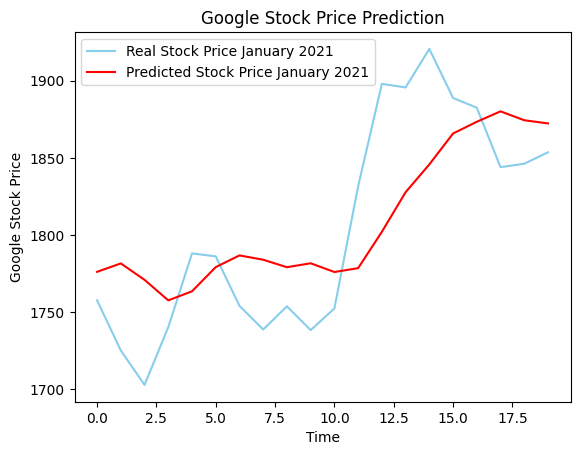

In [ ]:
#Visualizing the RNN model results
plt.plot(real_stock_price, color = 'skyblue', label = "Real Stock Price January 2021")
plt.plot(predicted_stock_price, color = 'red', label = "Predicted Stock Price January 2021")
plt.title("Google Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Google Stock Price")
plt.legend()
plt.show()